In [46]:
import polars as pl
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from IPython.display import display

DATA_PATH = Path().cwd().parent / "data"

def read_data(file_name):
    return pl.read_csv(DATA_PATH / file_name, try_parse_dates=True)

ship_df = read_data("shipments.csv")
purchase_df = read_data("purchase_orders.csv")
suppliers_df = read_data("suppliers.csv")
sku_df = read_data("skus.csv")
transit_events_df = read_data("transit_events.csv")
sites_df = read_data("sites.csv")
deployments_df = read_data("deployments.csv")
rma_returns_df = read_data("rma_returns.csv")
inventory_df = read_data("inventory_snapshots.csv")

Total RMA rows: 40,000


rma_id,sku_id,site_id,reason_code,rma_date,under_warranty
str,str,str,str,date,bool
"""RMA-0007663""","""SKU-04966""","""ST-00137""","""OVERHEAT""",2025-04-21,true
"""RMA-0018401""","""SKU-04714""","""ST-00378""","""RF_FAULT""",2023-11-25,true
"""RMA-0020987""","""SKU-01949""","""ST-01492""","""OTHER""",2025-10-13,false
"""RMA-0006905""","""SKU-01004""","""ST-00057""","""RF_FAULT""",2024-12-24,false
"""RMA-0021132""","""SKU-02349""","""ST-01434""","""NO_POWER""",2025-03-31,false


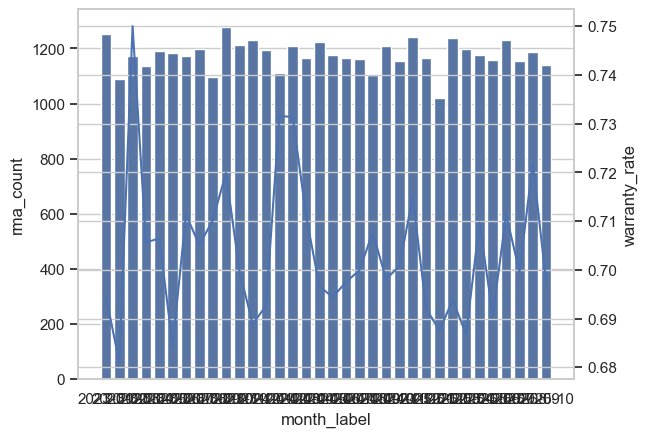

In [47]:
# Step 1: Inspect base RMA data, visualize volume & warranty rate, validate with raw rows
rma_base = (
    rma_returns_df
    .with_columns([
        pl.col("rma_date").cast(pl.Date),
        pl.col("under_warranty").cast(pl.Boolean)
    ])
    .sort("rma_date")
)

print(f"Total RMA rows: {rma_base.height:,}")
display(rma_base.select(["rma_id", "sku_id", "site_id", "reason_code", "rma_date", "under_warranty"]).sample(5, seed=42))

rma_monthly = (
    rma_base
    .group_by_dynamic("rma_date", every="1mo", period="1mo", label="left")
    .agg([
        pl.len().alias("rma_count"),
        pl.col("under_warranty").cast(pl.Int8).mean().alias("warranty_rate")
    ])
    .sort("rma_date")
    .to_pandas()
 )
rma_monthly["rma_date"] = pd.to_datetime(rma_monthly["rma_date"])
rma_monthly["month_label"] = rma_monthly["rma_date"].dt.strftime("%Y-%m")

fig, ax1 = plt.subplots()
sns.barplot(data=rma_monthly, x="month_label", y="rma_count", ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=rma_monthly, x="month_label", y="warranty_rate", ax=ax2)
plt.xticks(rotation=45)
plt.show()

Post SKU join rows: 40,000


rma_id,sku_id,vendor,category,technology,std_cost_usd
str,str,str,str,str,f64
"""RMA-0010156""","""SKU-00042""","""Nokia""","""Fiber""","""5G""",151.67
"""RMA-0029665""","""SKU-02994""","""Juniper""","""Antenna""","""5G""",597.06
"""RMA-0023194""","""SKU-03205""","""HPE Aruba""","""Antenna""","""4G""",348.63
"""RMA-0031265""","""SKU-02332""","""HPE Aruba""","""Antenna""","""4G""",259.07
"""RMA-0027827""","""SKU-02141""","""Huawei""","""RAN""","""5G""",124.76


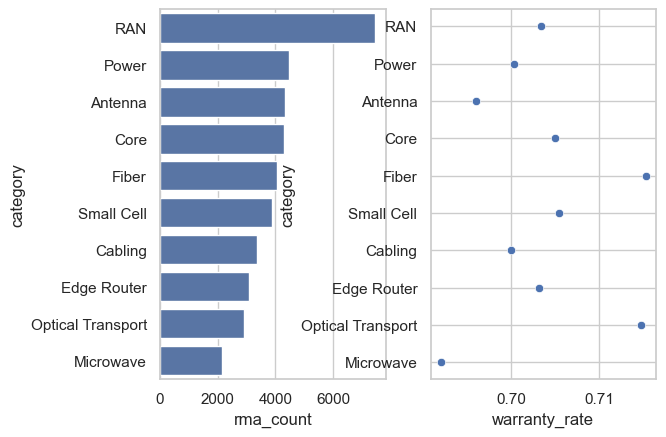

In [48]:
# Step 2: LEFT JOIN SKU attributes
rma_with_sku = (
    rma_base
    .join(sku_df, on="sku_id", how="left", suffix="_sku")
)

print(f"Post SKU join rows: {rma_with_sku.height:,}")
display(rma_with_sku.select([
    "rma_id", "sku_id", "vendor", "category", "technology", "std_cost_usd"
]).sample(5, seed=7))

sku_summary = (
    rma_with_sku
    .group_by("category")
    .agg([
        pl.len().alias("rma_count"),
        pl.col("under_warranty").cast(pl.Int8).mean().alias("warranty_rate")
    ])
    .sort("rma_count", descending=True)
    .head(10)
    .to_pandas()
 )

fig, axes = plt.subplots(1, 2)
sns.barplot(data=sku_summary, x="rma_count", y="category", ax=axes[0])
sns.scatterplot(data=sku_summary, x="warranty_rate", y="category", ax=axes[1])
plt.show()

Post Site join rows: 40,000


rma_id,site_id,region,country,site_type,operator
str,str,str,str,str,str
"""RMA-0011271""","""ST-01983""","""EMEA""","""Netherlands""","""Cell Site""","""Deutsche Telekom"""
"""RMA-0034082""","""ST-01514""","""AMER""","""Argentina""","""Cell Site""","""Rogers"""
"""RMA-0033775""","""ST-01883""","""EMEA""","""Poland""","""Data Center""","""Three"""
"""RMA-0014806""","""ST-00354""","""AMER""","""Chile""","""Data Center""","""Claro"""
"""RMA-0018556""","""ST-01802""","""EMEA""","""France""","""Cell Site""","""Telia"""


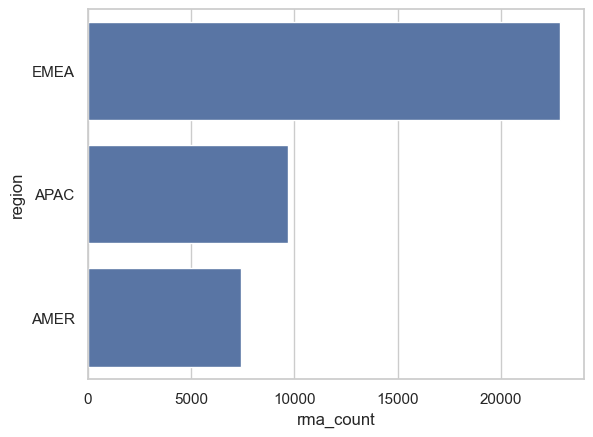

In [49]:
# Step 3: LEFT JOIN site metadata
rma_with_site = (
    rma_with_sku
    .join(sites_df, on="site_id", how="left", suffix="_site")
)

print(f"Post Site join rows: {rma_with_site.height:,}")
display(rma_with_site.select([
    "rma_id", "site_id", "region", "country", "site_type", "operator"
]).sample(5, seed=21))

region_summary = (
    rma_with_site
    .group_by("region")
    .agg([
        pl.len().alias("rma_count"),
        pl.col("under_warranty").cast(pl.Int8).mean().alias("warranty_rate")
    ])
    .sort("rma_count", descending=True)
    .to_pandas()
 )

fig, ax = plt.subplots()
sns.barplot(data=region_summary, x="rma_count", y="region", ax=ax)
plt.show()

Post PO join rows: 40,000


sku_id,last_order_date,avg_unit_price_by_sku,supplier_id_most_common
str,date,f64,str
"""SKU-00001""",2025-10-26,378.759706,"""S-0176"""
"""SKU-00002""",2025-10-21,1020.65697,"""S-0003"""
"""SKU-00003""",2025-08-08,1081.139259,"""S-0005"""
"""SKU-00004""",2025-10-17,574.687429,"""S-0187"""
"""SKU-00005""",2025-09-28,1636.711613,"""S-0177"""


rma_id,sku_id,last_order_date,avg_unit_price_by_sku,supplier_id_most_common
str,str,date,f64,str
"""RMA-0008542""","""SKU-03784""",2025-10-14,553.964062,"""S-0082"""
"""RMA-0023024""","""SKU-00226""",2025-10-16,408.425758,"""S-0112"""
"""RMA-0008491""","""SKU-01216""",2025-10-27,54.394545,"""S-0102"""
"""RMA-0006417""","""SKU-01001""",2025-10-11,974.161379,"""S-0110"""
"""RMA-0007697""","""SKU-02958""",2025-10-02,164.0104,"""S-0047"""


C:\Users\skibi\AppData\Local\Temp\ipykernel_15844\4037075502.py:60: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()
e:\task\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


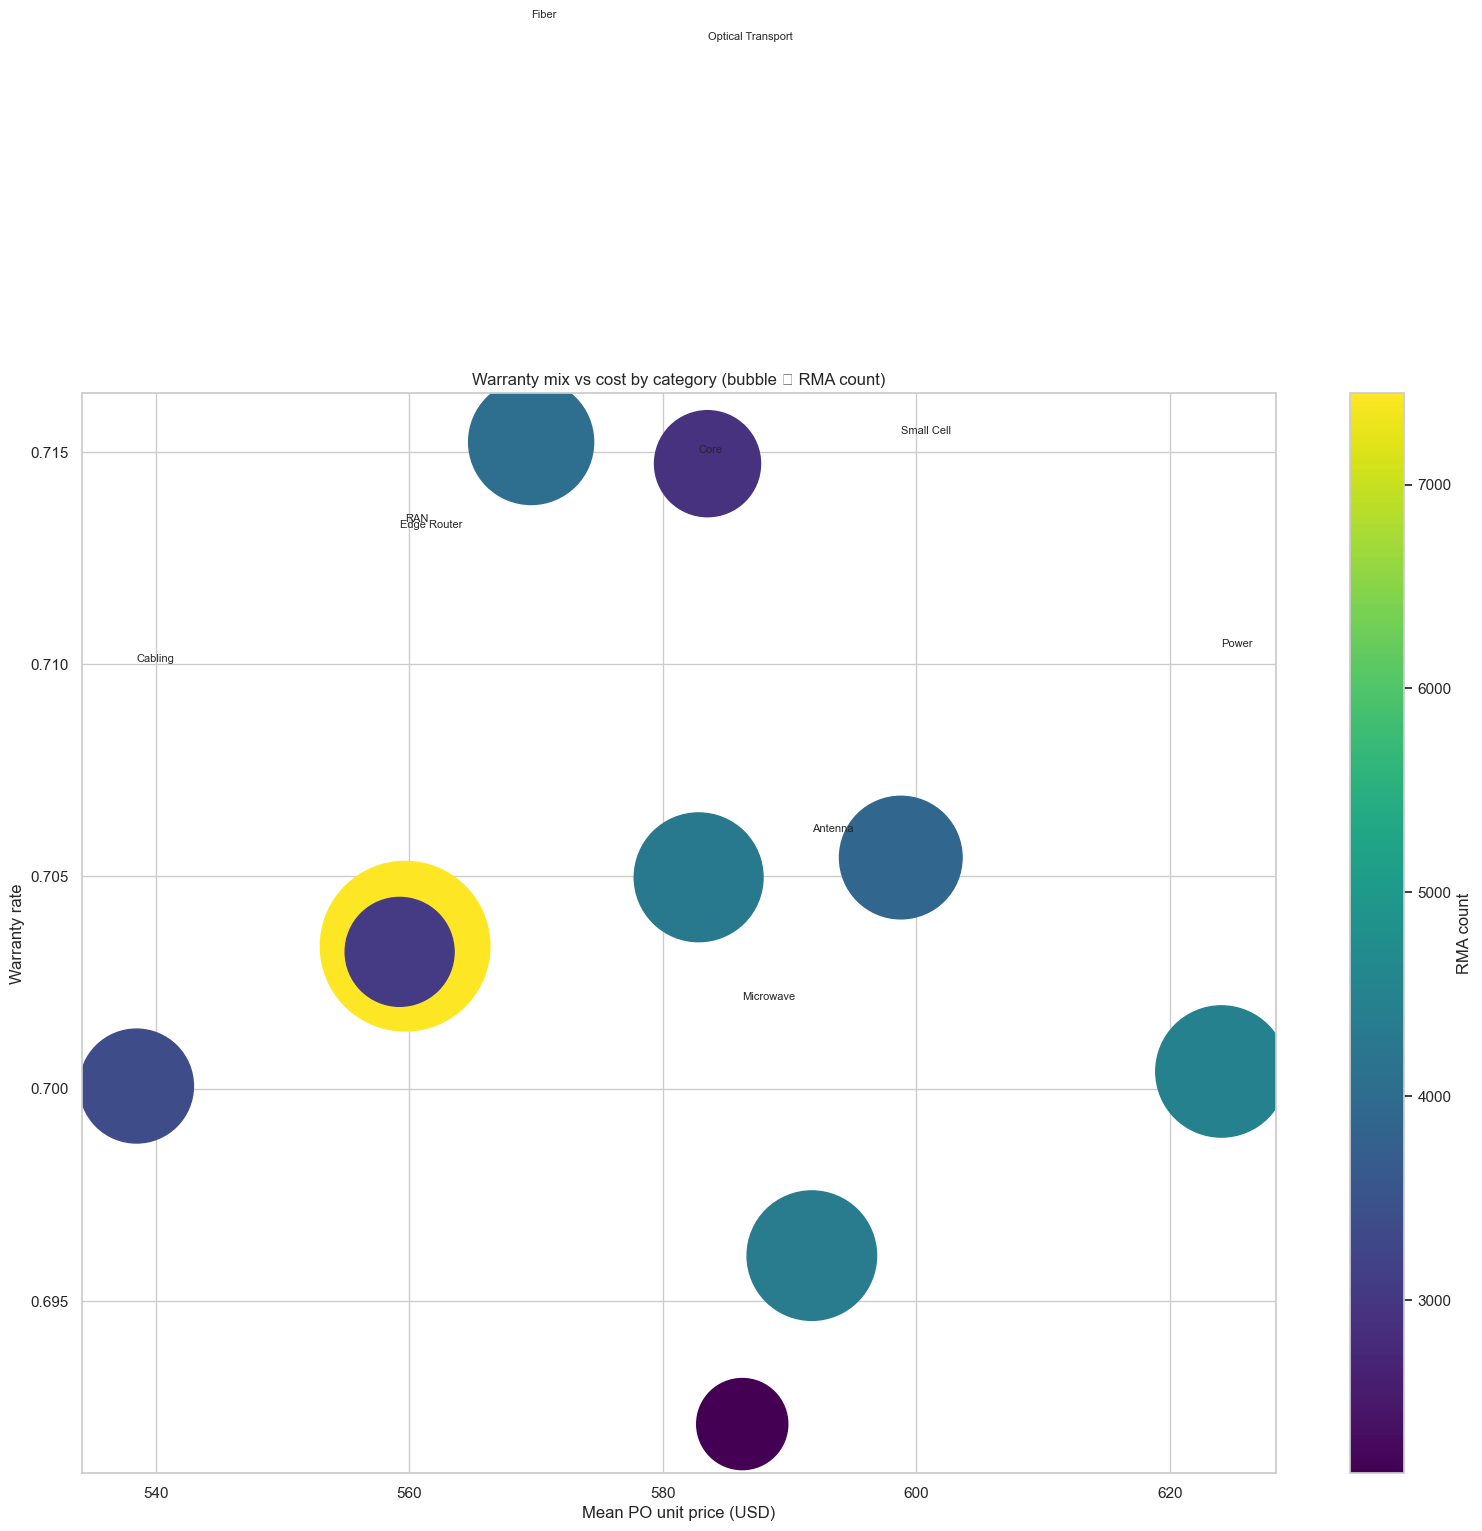

In [50]:
# Step 4: Aggregate purchase orders per SKU and join
purchase_enriched = purchase_df.with_columns(pl.col("order_date").cast(pl.Date))

po_basic = (
    purchase_enriched
    .group_by("sku_id")
    .agg([
        pl.col("order_date").max().alias("last_order_date"),
        pl.col("unit_price_usd").mean().alias("avg_unit_price_by_sku")
    ])
)

po_supplier = (
    purchase_enriched
    .group_by(["sku_id", "supplier_id"])
    .agg(pl.len().alias("po_count"))
    .sort(["sku_id", "po_count"], descending=[False, True])
    .unique(subset="sku_id", keep="first")
    .select(["sku_id", pl.col("supplier_id").alias("supplier_id_most_common")])
)

po_aggregates = po_basic.join(po_supplier, on="sku_id", how="left")

rma_with_po = rma_with_site.join(po_aggregates, on="sku_id", how="left")

print(f"Post PO join rows: {rma_with_po.height:,}")
display(po_aggregates.sort("sku_id").head(5))
display(rma_with_po.select([
    "rma_id", "sku_id", "last_order_date", "avg_unit_price_by_sku", "supplier_id_most_common"
]).sample(5, seed=99))

price_vs_warranty = (
    rma_with_po
    .filter(pl.col("avg_unit_price_by_sku").is_not_null())
    .group_by("category")
    .agg([
        pl.col("avg_unit_price_by_sku").mean().alias("mean_unit_price"),
        pl.col("under_warranty").cast(pl.Int8).mean().alias("warranty_rate"),
        pl.len().alias("rma_count")
    ])
    .sort("rma_count", descending=True)
    .head(12)
    .to_pandas()
)

fig, ax = plt.subplots(figsize=(16, 16))
scatter = ax.scatter(
    price_vs_warranty["mean_unit_price"],
    price_vs_warranty["warranty_rate"],
    s=price_vs_warranty["rma_count"] * 2,
    c=price_vs_warranty["rma_count"],
    cmap="viridis"
)
for _, row in price_vs_warranty.iterrows():
    ax.text(row["mean_unit_price"], row["warranty_rate"] + 0.01, row["category"], fontsize=8)
ax.set_xlabel("Mean PO unit price (USD)")
ax.set_ylabel("Warranty rate")
ax.set_title("Warranty mix vs cost by category (bubble ∝ RMA count)")
plt.colorbar(scatter, label="RMA count")
plt.tight_layout()
plt.show()

Post inventory join rows: 40,000


C:\Users\skibi\AppData\Local\Temp\ipykernel_15844\1978033150.py:13: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  rma_with_inventory = rma_for_join.join_asof(


rma_id,sku_id,snapshot_date,on_hand_qty,allocated_qty,in_transit_qty
str,str,date,i64,i64,i64
"""RMA-0036501""","""SKU-03207""",null,null,null,null
"""RMA-0034777""","""SKU-04187""",null,null,null,null
"""RMA-0030928""","""SKU-03314""",2025-06-13,13,6,2
"""RMA-0013910""","""SKU-02611""",2025-02-19,5,2,3
"""RMA-0018262""","""SKU-00275""",2025-05-04,7,1,2


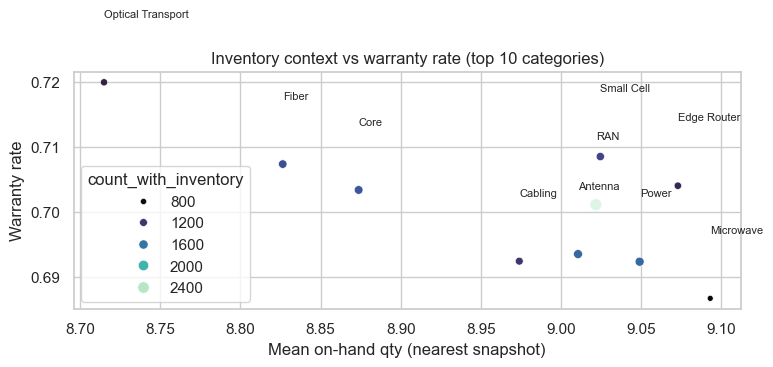

In [51]:
# Step 5 (optional): Attach nearest inventory snapshot per SKU (snapshot_date <= rma_date)
inventory_prepared = (
    inventory_df
    .with_columns([
        pl.col("snapshot_date").cast(pl.Date)
    ])
    .sort(["sku_id", "snapshot_date"])
)

rma_for_join = rma_with_po.sort(["sku_id", "rma_date"])
inventory_for_join = inventory_prepared.sort(["sku_id", "snapshot_date"])

rma_with_inventory = rma_for_join.join_asof(
    inventory_for_join,
    left_on="rma_date",
    right_on="snapshot_date",
    by="sku_id",
    strategy="backward",
    suffix="_inventory"
)

print(f"Post inventory join rows: {rma_with_inventory.height:,}")
display(rma_with_inventory.select([
    "rma_id", "sku_id", "snapshot_date", "on_hand_qty", "allocated_qty", "in_transit_qty"
]).sample(5, seed=123))

inventory_summary = (
    rma_with_inventory
    .filter(pl.col("on_hand_qty").is_not_null())
    .group_by("category")
    .agg([
        pl.col("on_hand_qty").mean().alias("mean_on_hand"),
        pl.col("under_warranty").cast(pl.Int8).mean().alias("warranty_rate"),
        pl.len().alias("count_with_inventory")
    ])
    .sort("count_with_inventory", descending=True)
    .head(10)
    .to_pandas()
)

fig, ax = plt.subplots(figsize=(8, 4))
sns.scatterplot(
    data=inventory_summary,
    x="mean_on_hand",
    y="warranty_rate",
    size="count_with_inventory",
    hue="count_with_inventory",
    palette="mako",
    ax=ax
 )
for _, row in inventory_summary.iterrows():
    ax.text(row["mean_on_hand"], row["warranty_rate"] + 0.01, row["category"], fontsize=8)
ax.set_xlabel("Mean on-hand qty (nearest snapshot)")
ax.set_ylabel("Warranty rate")
ax.set_title("Inventory context vs warranty rate (top 10 categories)")
plt.tight_layout()
plt.show()

shape: (2, 2)
┌──────────────────┬───────┐
│ y_under_warranty ┆ count │
│ ---              ┆ ---   │
│ i8               ┆ u32   │
╞══════════════════╪═══════╡
│ 1                ┆ 28150 │
│ 0                ┆ 11850 │
└──────────────────┴───────┘


rma_id,sku_id,site_id,y_under_warranty,reason_code,region,last_order_date
str,str,str,i8,str,str,date
"""RMA-0038886""","""SKU-02611""","""ST-01657""",1,"""RF_FAULT""","""APAC""",2025-10-15
"""RMA-0001364""","""SKU-01469""","""ST-00513""",0,"""DOA""","""EMEA""",2025-10-28
"""RMA-0038520""","""SKU-01207""","""ST-01887""",1,"""INTERMITTENT""","""EMEA""",2025-06-17
"""RMA-0015080""","""SKU-02094""","""ST-01661""",1,"""OTHER""","""EMEA""",2025-10-25
"""RMA-0026491""","""SKU-03736""","""ST-01535""",1,"""OTHER""","""AMER""",2025-10-10


C:\Users\skibi\AppData\Local\Temp\ipykernel_15844\3198156176.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=target_viz, x="y_under_warranty", palette="pastel", ax=ax)
C:\Users\skibi\AppData\Local\Temp\ipykernel_15844\3198156176.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Out of warranty", "Under warranty"])


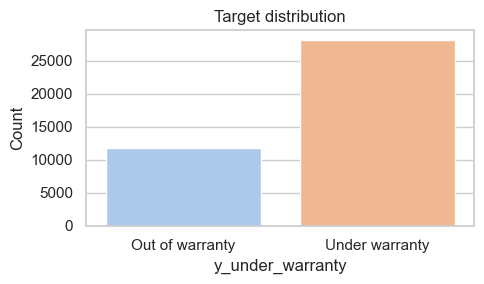

In [52]:
# Step 6: Create target + handle missing values (dates->NULL, categoricals->'UNKNOWN')
date_columns = [col for col, dtype in rma_with_inventory.schema.items() if dtype in (pl.Date, pl.Datetime)]
categorical_columns = [col for col, dtype in rma_with_inventory.schema.items() if dtype == pl.Utf8]

date_clean_exprs = []
for col in date_columns:
    date_clean_exprs.append(
        pl.when(
            (pl.col(col).cast(pl.Utf8).str.strip_chars() == "")
        ).then(None).otherwise(pl.col(col)).alias(col)
    )

categorical_fill_exprs = []
for col in categorical_columns:
    categorical_fill_exprs.append(
        pl.when(
            pl.col(col).is_null() | (pl.col(col).str.strip_chars() == "")
        ).then(pl.lit("UNKNOWN")).otherwise(pl.col(col)).alias(col)
    )

rma_final = (
    rma_with_inventory
    .with_columns(
        date_clean_exprs + categorical_fill_exprs + [
            pl.col("under_warranty").cast(pl.Int8).alias("y_under_warranty")
        ]
    )
)

print(rma_final.select(pl.col("y_under_warranty")).to_series().value_counts())
display(rma_final.select([
    "rma_id", "sku_id", "site_id", "y_under_warranty", "reason_code", "region", "last_order_date"
]).sample(5, seed=2024))

target_viz = rma_final.select(["y_under_warranty", "reason_code"]).to_pandas()
fig, ax = plt.subplots(figsize=(5, 3))
sns.countplot(data=target_viz, x="y_under_warranty", palette="pastel", ax=ax)
ax.set_xticklabels(["Out of warranty", "Under warranty"])
ax.set_ylabel("Count")
ax.set_title("Target distribution")
plt.tight_layout()
plt.show()

C:\Users\skibi\AppData\Local\Temp\ipykernel_15844\4146349189.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(add_rolling_features)


,rma_id,sku_id,vendor,supplier_id_feature,month_of_rma,days_since_last_po,avg_unit_price_diff,avg_order_qty_by_sku,avg_cost_by_vendor,rma_rate_last_12m
4,RMA-0019548,SKU-04709,Nokia,S-0195,12,-278,40.092963,9.296296,532.378382,0.166667
6,RMA-0012960,SKU-04976,Cisco,S-0175,10,-368,4.536087,9.434783,595.493062,0.333333
11,RMA-0010671,SKU-04650,Samsung,S-0092,10,-7,53.314783,8.086957,600.208671,0.250000
1,RMA-0022388,SKU-01720,Ciena,S-0198,10,-720,10.508810,9.095238,598.297610,0.166667
2,RMA-0023945,SKU-02721,HPE Aruba,S-0061,6,-505,10.106667,8.518519,637.121675,0.166667


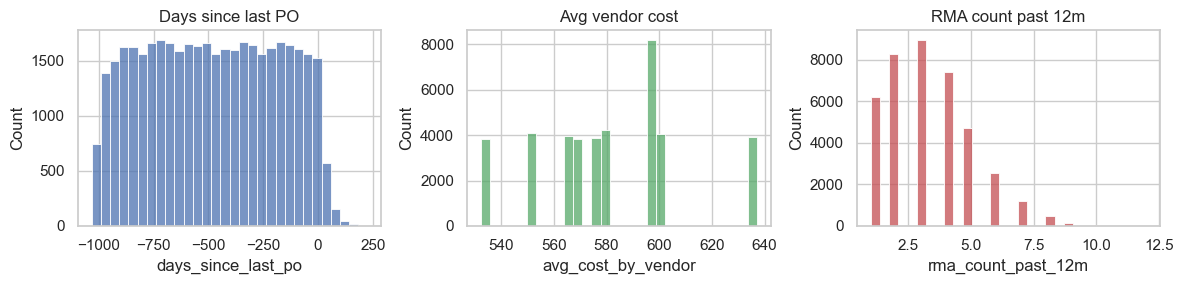

In [53]:
# Step 7: Feature engineering per specification
avg_order_qty = (
    purchase_df
    .group_by("sku_id")
    .agg(pl.col("order_qty").mean().alias("avg_order_qty_by_sku"))
)
vendor_avg_cost = (
    purchase_df
    .join(sku_df.select(["sku_id", "vendor"]), on="sku_id", how="left")
    .group_by("vendor")
    .agg(pl.col("unit_price_usd").mean().alias("avg_cost_by_vendor"))
)

enriched_pl = (
    rma_final
    .join(avg_order_qty, on="sku_id", how="left")
    .join(vendor_avg_cost, on="vendor", how="left")
    .with_columns([
        pl.col("rma_date").dt.month().alias("month_of_rma"),
        pl.col("rma_date").dt.year().alias("rma_year"),
        (pl.col("rma_date") - pl.col("last_order_date")).dt.total_days().alias("days_since_last_po"),
        (pl.col("rma_date") - pl.col("last_order_date")).dt.total_days().alias("approx_item_age_days"),
        (pl.col("avg_unit_price_by_sku") - pl.col("std_cost_usd")).alias("avg_unit_price_diff"),
        pl.col("avg_unit_price_by_sku").alias("avg_unit_price_usd"),
        pl.when(pl.col("region") == "AMER").then(pl.lit("Americas"))
         .when(pl.col("region") == "APAC").then(pl.lit("AsiaPacific"))
         .when(pl.col("region") == "EMEA").then(pl.lit("EMEA"))
         .otherwise(pl.lit("Other")).alias("country_group"),
        pl.when(pl.col("latitude").abs() >= 55).then(pl.lit(1))
         .when(pl.col("latitude").abs() <= 15).then(pl.lit(1))
         .otherwise(pl.lit(0)).alias("is_extreme_climate"),
        pl.col("on_hand_qty").alias("on_hand_qty_at_site"),
        pl.col("in_transit_qty").alias("in_transit_qty_at_site"),
        pl.col("supplier_id_most_common").alias("supplier_id_feature"),
        pl.col("avg_order_qty_by_sku"),
        pl.col("avg_cost_by_vendor")
    ])
)

model_features_df = enriched_pl.to_pandas()
model_features_df["rma_date"] = pd.to_datetime(model_features_df["rma_date"])
model_features_df["last_order_date"] = pd.to_datetime(model_features_df["last_order_date"])

def add_rolling_features(group):
    group = group.sort_values("rma_date").set_index("rma_date")
    count_roll = group["y_under_warranty"].rolling("365D").count()
    warranty_roll = group["y_under_warranty"].rolling("365D").mean()
    group = group.reset_index()
    group["rma_count_past_12m"] = count_roll.values
    group["warranty_rate_past_12m"] = warranty_roll.values
    return group

model_features_df = (
    model_features_df
    .groupby("sku_id", group_keys=False)
    .apply(add_rolling_features)
)
model_features_df["rma_rate_past_12m"] = (model_features_df["rma_count_past_12m"].fillna(0) / 365.0)
model_features_df["rma_rate_last_12m"] = (model_features_df["rma_count_past_12m"].fillna(0) / 12.0)
model_features_df["warranty_rate_past_12m"] = model_features_df["warranty_rate_past_12m"].fillna(model_features_df["y_under_warranty"].mean())
model_features_df["days_since_last_po"] = model_features_df["days_since_last_po"].fillna(model_features_df["days_since_last_po"].median())
model_features_df["approx_item_age_days"] = model_features_df["approx_item_age_days"].fillna(model_features_df["approx_item_age_days"].median())
model_features_df["avg_unit_price_diff"] = model_features_df["avg_unit_price_diff"].fillna(0)
model_features_df["avg_order_qty_by_sku"] = model_features_df["avg_order_qty_by_sku"].fillna(model_features_df["avg_order_qty_by_sku"].median())
model_features_df["on_hand_qty_at_site"] = model_features_df["on_hand_qty_at_site"].fillna(0)
model_features_df["in_transit_qty_at_site"] = model_features_df["in_transit_qty_at_site"].fillna(0)
model_features_df["avg_cost_by_vendor"] = model_features_df["avg_cost_by_vendor"].fillna(model_features_df["avg_cost_by_vendor"].median())
model_features_df["month_of_rma"] = model_features_df["month_of_rma"].fillna(model_features_df["month_of_rma"].mode().iloc[0])

feature_preview_cols = [
    "rma_id", "sku_id", "vendor", "supplier_id_feature", "month_of_rma", "days_since_last_po",
    "avg_unit_price_diff", "avg_order_qty_by_sku", "avg_cost_by_vendor", "rma_rate_last_12m"
]
display(model_features_df[feature_preview_cols].sample(5, random_state=15))

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.histplot(model_features_df["days_since_last_po"], ax=axes[0], bins=30, color="#4C72B0")
axes[0].set_title("Days since last PO")
sns.histplot(model_features_df["avg_cost_by_vendor"], ax=axes[1], bins=30, color="#55A868")
axes[1].set_title("Avg vendor cost")
sns.histplot(model_features_df["rma_count_past_12m"], ax=axes[2], bins=30, color="#C44E52")
axes[2].set_title("RMA count past 12m")
plt.tight_layout()
plt.show()

,split,rows,start,end,warranty_rate
0,train,28000,2023-01-01,2024-12-23,0.705429
1,val,6000,2024-12-23,2025-05-28,0.696333
2,test,6000,2025-05-28,2025-10-30,0.703333


C:\Users\skibi\AppData\Local\Temp\ipykernel_15844\3271085326.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("3M")
C:\Users\skibi\AppData\Local\Temp\ipykernel_15844\3271085326.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("3M")
C:\Users\skibi\AppData\Local\Temp\ipykernel_15844\3271085326.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("3M")


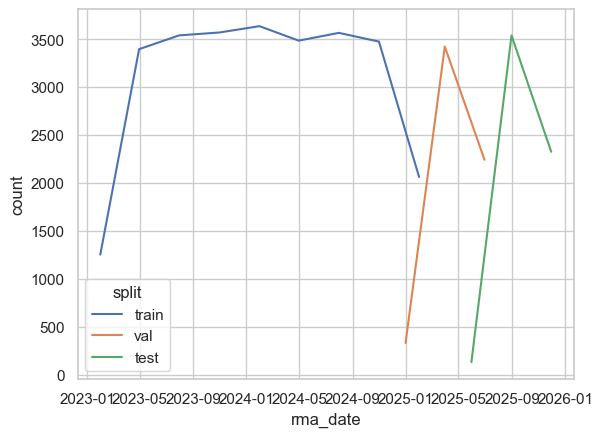

Sample rows from train split:


,rma_id,sku_id,rma_date,region,reason_code,y_under_warranty
0,RMA-0023709,SKU-02664,2023-01-01,AMER,NO_POWER,1
1,RMA-0036966,SKU-04536,2023-01-01,EMEA,RF_FAULT,0
2,RMA-0017649,SKU-00730,2023-01-01,AMER,RF_FAULT,0


Sample rows from val split:


,rma_id,sku_id,rma_date,region,reason_code,y_under_warranty
28000,RMA-0021834,SKU-00412,2024-12-23,EMEA,INTERMITTENT,1
28001,RMA-0009373,SKU-02397,2024-12-23,AMER,OTHER,0
28002,RMA-0012221,SKU-01403,2024-12-23,APAC,FIRMWARE,1


Sample rows from test split:


,rma_id,sku_id,rma_date,region,reason_code,y_under_warranty
34000,RMA-0038887,SKU-01729,2025-05-28,APAC,FIRMWARE,1
34001,RMA-0000908,SKU-01968,2025-05-28,APAC,MECH_DAMAGE,1
34002,RMA-0022426,SKU-01050,2025-05-28,EMEA,NO_POWER,0


In [54]:
# Step 8: Time-aware Train/Val/Test split with validation visuals
model_features_df = model_features_df.sort_values("rma_date").reset_index(drop=True)
n_rows = len(model_features_df)
train_end = int(0.70 * n_rows)
val_end = int(0.85 * n_rows)

train_df = model_features_df.iloc[:train_end].copy()
val_df = model_features_df.iloc[train_end:val_end].copy()
test_df = model_features_df.iloc[val_end:].copy()
splits = {"train": train_df, "val": val_df, "test": test_df}

split_summary = []
for split_name, split_df in splits.items():
    split_summary.append({
        "split": split_name,
        "rows": len(split_df),
        "start": split_df["rma_date"].min(),
        "end": split_df["rma_date"].max(),
        "warranty_rate": split_df["y_under_warranty"].mean()
    })
display(pd.DataFrame(split_summary))

monthly_view = []
for split_name, split_df in splits.items():
    tmp = (
        split_df
        .set_index("rma_date")
        .resample("3M")
        .size()
        .rename("count")
        .to_frame()
        .assign(split=split_name)
        .reset_index()
    )
    monthly_view.append(tmp)
monthly_view = pd.concat(monthly_view)

fig, ax = plt.subplots()
sns.lineplot(data=monthly_view, x="rma_date", y="count", hue="split", ax=ax)
plt.show()

for split_name, split_df in splits.items():
    print(f"Sample rows from {split_name} split:")
    display(split_df[["rma_id", "sku_id", "rma_date", "region", "reason_code", "y_under_warranty"]].head(3))

all_df = pd.concat(splits).reset_index(level=0).rename(columns={"level_0": "split"})
all_df = all_df.set_index("split", append=True).swaplevel(0, 1).sort_index()

Encoded feature matrix shape (train): (28000, 35)


,unit_weight_kg,unit_volume_m3,std_cost_usd,supplier_nominal_lead_time_days,latitude,longitude,is_extreme_climate,avg_unit_price_usd,avg_unit_price_diff,days_since_last_po,...,reason_code_NO_POWER,reason_code_OTHER,reason_code_OVERHEAT,reason_code_RF_FAULT,region_APAC,region_EMEA,site_type_Data Center,site_type_Integration Center,site_type_Warehouse,y_under_warranty
0,0.541200,0.609309,-0.605786,-0.351283,-1.250676,-1.815601,1.659444,-0.616994,-0.756106,-1.825496,...,True,False,False,False,False,False,False,False,False,1
1,0.966364,0.952528,-0.562613,-1.000542,0.133576,-0.356464,-0.602612,-0.567916,-0.608125,-1.812186,...,False,False,False,True,False,True,False,True,False,0
2,-0.730714,-0.667754,-0.657240,0.582028,-1.193901,-1.427709,1.659444,-0.663965,-0.720165,-1.702380,...,False,False,False,True,False,False,False,False,True,0


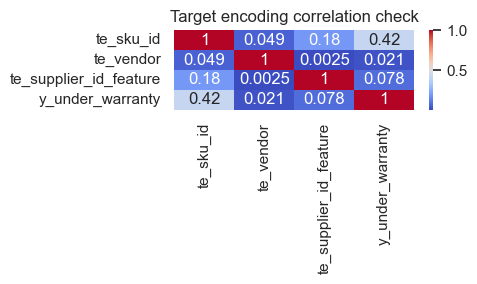

In [55]:
# Step 9: Encoding + scaling
target = "y_under_warranty"
categorical_target_enc = ["sku_id", "vendor", "supplier_id_feature"]
categorical_one_hot = ["reason_code", "region", "site_type"]
numeric_cols = [
    "unit_weight_kg", "unit_volume_m3", "std_cost_usd", "supplier_nominal_lead_time_days",
    "latitude", "longitude", "is_extreme_climate", "avg_unit_price_usd", "avg_unit_price_diff",
    "days_since_last_po", "approx_item_age_days", "avg_order_qty_by_sku", "avg_cost_by_vendor",
    "on_hand_qty_at_site", "in_transit_qty_at_site", "month_of_rma", "rma_year",
    "rma_rate_past_12m", "rma_rate_last_12m", "warranty_rate_past_12m"
 ]

train_all = all_df.xs("train")

target_encodings = {}
for col in categorical_target_enc:
    mapping = train_all.groupby(col)[target].mean()
    prior = train_all[target].mean()
    mapping = mapping.to_dict()
    target_encodings[col] = mapping
    all_df[f"te_{col}"] = all_df[col].map(mapping).fillna(prior)

all_df = pd.get_dummies(all_df, columns=categorical_one_hot, drop_first=True)

numeric_cols_updated = [col for col in numeric_cols if col in all_df.columns]
scaler = StandardScaler()
all_df[numeric_cols_updated] = scaler.fit_transform(all_df[numeric_cols_updated])

feature_matrix_cols = numeric_cols_updated + [col for col in all_df.columns if col.startswith("te_") or col.startswith("reason_code_") or col.startswith("region_") or col.startswith("site_type_")]
feature_matrix_cols = list(dict.fromkeys(feature_matrix_cols))

train_encoded = all_df.xs("train")
val_encoded = all_df.xs("val")
test_encoded = all_df.xs("test")

print(f"Encoded feature matrix shape (train): {train_encoded[feature_matrix_cols].shape}")
display(train_encoded[feature_matrix_cols + [target]].head(3))

fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(train_encoded[["te_sku_id", "te_vendor", "te_supplier_id_feature", target]].corr(), annot=True, cmap="coolwarm", ax=ax)
ax.set_title("Target encoding correlation check")
plt.tight_layout()
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19752, number of negative: 8248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3018
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.705429 -> initscore=0.873284
[LightGBM] [Info] Start training from score 0.873284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

,model,auc,ap,precision@5%,brier
0,LightGBM,0.804002,0.911543,1.0,0.167656
1,RandomForest,0.783558,0.904799,1.0,0.164242
2,LogReg,0.850829,0.934625,1.0,0.158429


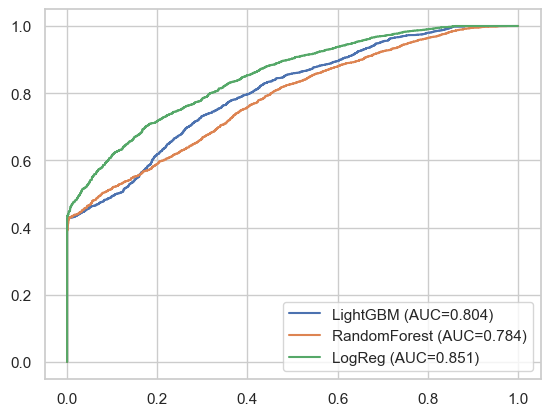

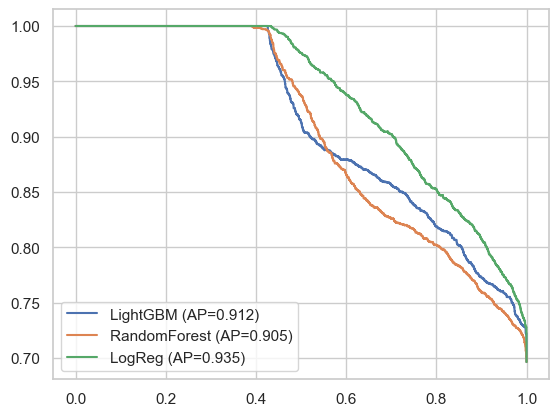

LightGBM Brier (val): 0.1677 | Brier (test): 0.1572


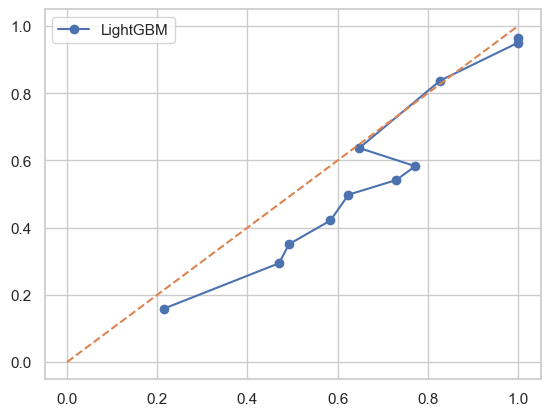

In [56]:
# Step 10: Model training (LightGBM, RandomForest, LogisticRegression)
X_train = train_encoded[feature_matrix_cols]
y_train = train_encoded[target]
X_val = val_encoded[feature_matrix_cols]
y_val = val_encoded[target]
X_test = test_encoded[feature_matrix_cols]
y_test = test_encoded[target]

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)
class_ratio = (1 - y_train.mean()) / y_train.mean()

lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 63,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "max_depth": 6,
    "min_data_in_leaf": 150,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "scale_pos_weight": class_ratio,
    "seed": 42
}
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1200,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[lgb.early_stopping(50)]
)

rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=14,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

log_reg = LogisticRegression(max_iter=1000, C=0.8, class_weight="balanced", solver="lbfgs")
log_reg.fit(X_train, y_train)

def precision_at_top_k(y_true, proba, pct=0.05):
    proba = np.asarray(proba)
    k = max(1, int(np.ceil(len(proba) * pct)))
    top_idx = np.argpartition(proba, -k)[-k:]
    return y_true.iloc[top_idx].mean()

def evaluate_model(model_name, model, X, y):
    proba = model.predict(X) if model_name == "LightGBM" else model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, proba)
    return {
        "model": model_name,
        "auc": roc_auc_score(y, proba),
        "ap": average_precision_score(y, proba),
        "precision@5%": precision_at_top_k(y.reset_index(drop=True), proba),
        "fpr": roc_curve(y, proba)[0],
        "tpr": roc_curve(y, proba)[1],
        "precision_curve": precision,
        "recall_curve": recall,
        "brier": brier_score_loss(y, proba)
    }

results = []
for name, model in [("LightGBM", lgb_model), ("RandomForest", rf_model), ("LogReg", log_reg)]:
    results.append(evaluate_model(name, model, X_val, y_val))

results_df = pd.DataFrame([{k: v for k, v in res.items() if k not in ["fpr", "tpr", "precision_curve", "recall_curve"]} for res in results])
display(results_df)

plt.figure()
for res in results:
    plt.plot(res["fpr"], res["tpr"], label=f"{res['model']} (AUC={res['auc']:.3f})")
plt.legend()
plt.show()

plt.figure()
for res in results:
    plt.plot(res["recall_curve"], res["precision_curve"], label=f"{res['model']} (AP={res['ap']:.3f})")
plt.legend()
plt.show()

lgb_val_proba = lgb_model.predict(X_val)
lgb_test_proba = lgb_model.predict(X_test)
val_brier = brier_score_loss(y_val, lgb_val_proba)
test_brier = brier_score_loss(y_test, lgb_test_proba)
print(f"LightGBM Brier (val): {val_brier:.4f} | Brier (test): {test_brier:.4f}")

calib_prob, calib_true = calibration_curve(y_val, lgb_val_proba, n_bins=12, strategy="quantile")
plt.figure()
plt.plot(calib_prob, calib_true, marker="o", label="LightGBM")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.legend()
plt.show()